In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from pathlib import Path

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

root = Path.cwd().parents[0] if 'notebooks' in str(Path.cwd()) else Path.cwd()
train_path = root / "data" / "raw" / "train.csv"


def rmsle(y_true, y_pred):
    """
    Root Mean Squared Logarithmic Error
    y_true: Gerçek değerler
    y_pred: Tahmin edilen değerler
    """
    y_pred = np.maximum(y_pred, 0)
    
    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)
    
    error = np.sqrt(np.mean((log_true - log_pred)**2))
    return error

print("Kütüphaneler yüklendi ve RMSLE fonksiyonu hazır.")

Kütüphaneler yüklendi ve RMSLE fonksiyonu hazır.


In [3]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


if 'train' not in globals():
    train = pd.read_csv(train_path, parse_dates=['datetime'])
    print("Veri diskten yüklendi.")


y = train['count']
# Leakage (Sızıntı) yaratacak casual ve registered sütunlarını atıyoruz
X = train.drop(['count', 'casual', 'registered'], axis=1)

# 3. Train - Validation Ayrımı (%80 Train, %20 Val)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)


mean_prediction = y_train.mean()

y_pred_naive = np.full(shape=len(y_val), fill_value=mean_prediction)

naive_rmsle = rmsle(y_val, y_pred_naive)
naive_mae = mean_absolute_error(y_val, y_pred_naive)
naive_r2 = r2_score(y_val, y_pred_naive)

print("-" * 40)
print(f"--- NAIVE MODEL (ORTALAMA) SONUÇLARI ---")
print(f"Tahmin Edilen Sabit Değer: {mean_prediction:.2f}")
print(f"RMSLE (Hedef Skorumuz):    {naive_rmsle:.5f}")
print(f"MAE (Ortalama Hata):       {naive_mae:.2f}")
print(f"R² (Başarı Oranı):         {naive_r2:.5f}")
print("-" * 40)

Veri diskten yüklendi.
----------------------------------------
--- NAIVE MODEL (ORTALAMA) SONUÇLARI ---
Tahmin Edilen Sabit Değer: 191.58
RMSLE (Hedef Skorumuz):    1.58724
MAE (Ortalama Hata):       142.70
R² (Başarı Oranı):         -0.00000
----------------------------------------


### İlk Deneme: Basit Lineer Regresyon

Sadece ortalamayı kullandığımız ilk modelde hata oranı (RMSLE: 1.58) oldukça yüksek çıktı. Şimdi verideki ipuçlarını kullanarak bu hatayı azaltmaya çalışacağım.

**Plan:**
1.  **Tarihi Sayıya Çevirme:** Bilgisayar tarihleri bizim gibi "Ocak ayı" veya "Saat 5" olarak anlamaz. Bu yüzden tarih sütunundan **Saat**, **Ay** ve **Yıl** bilgilerini çıkarıp sayısal hale getireceğim.
2.  **Model Seçimi:** En temel yöntem olan **Lineer Regresyon (Linear Regression)** kullanacağım.
3.  **Amaç:** Sıcaklık ve saat gibi bilgileri modele vererek, 1.58 olan hata skorunu düşürmek.

In [4]:
from sklearn.linear_model import LinearRegression


train['hour'] = train['datetime'].dt.hour
train['month'] = train['datetime'].dt.month
train['year'] = train['datetime'].dt.year


features = ['hour', 'year', 'month', 'temp', 'humidity', 'windspeed']

X = train[features]
y = train['count']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_val)

lr_rmsle = rmsle(y_val, y_pred_lr)
lr_mae = mean_absolute_error(y_val, y_pred_lr)
lr_r2 = r2_score(y_val, y_pred_lr)

print("-" * 40)
print(f"--- LINEAR REGRESSION SONUÇLARI ---")
print(f"RMSLE (Daha düşük iyi):  {lr_rmsle:.5f}  (Naive: {naive_rmsle:.5f})")
print(f"MAE (Ortalama Hata):     {lr_mae:.2f}    (Naive: {naive_mae:.2f})")
print(f"R² (Başarı Oranı):       {lr_r2:.5f}     (Naive: {naive_r2:.5f})")
print("-" * 40)

improvement = ((naive_rmsle - lr_rmsle) / naive_rmsle) * 100
print(f" İyileşme Oranı: %{improvement:.2f}")

----------------------------------------
--- LINEAR REGRESSION SONUÇLARI ---
RMSLE (Daha düşük iyi):  1.30207  (Naive: 1.58724)
MAE (Ortalama Hata):     105.27    (Naive: 142.70)
R² (Başarı Oranı):       0.39487     (Naive: -0.00000)
----------------------------------------
 İyileşme Oranı: %17.97


### Sonuçların Değerlendirilmesi

- **Gelişme Var mı?:** Evet, Lineer model, sadece ortalama alan modele göre hatayı **%18 azalttı** (RMSLE 1.58 -> 1.30).
- **Başarı Yeterli mi?:** Hayır. **R² = 0.39** çıkması, modelin bisiklet kiralama davranışının %60'ını hala çözemediğini gösteriyor.
- **Sebep:** Bisiklet talebi saatlere göre çok inişli çıkışlı (zikzaklı) bir yapıya sahip. Lineer Regresyon ise veriye **"dümdüz bir çizgi"** çekmeye çalıştığı için o ani artışları ve düşüşleri (örneğin sabah trafiğini) tam yakalayamıyor.

✅ Grafik kaydedildi: c:\Users\yedis\Desktop\yehu\Github Repo\BikeSharing-ML-Pipeline\figures\baseline_actual_vs_pred.png


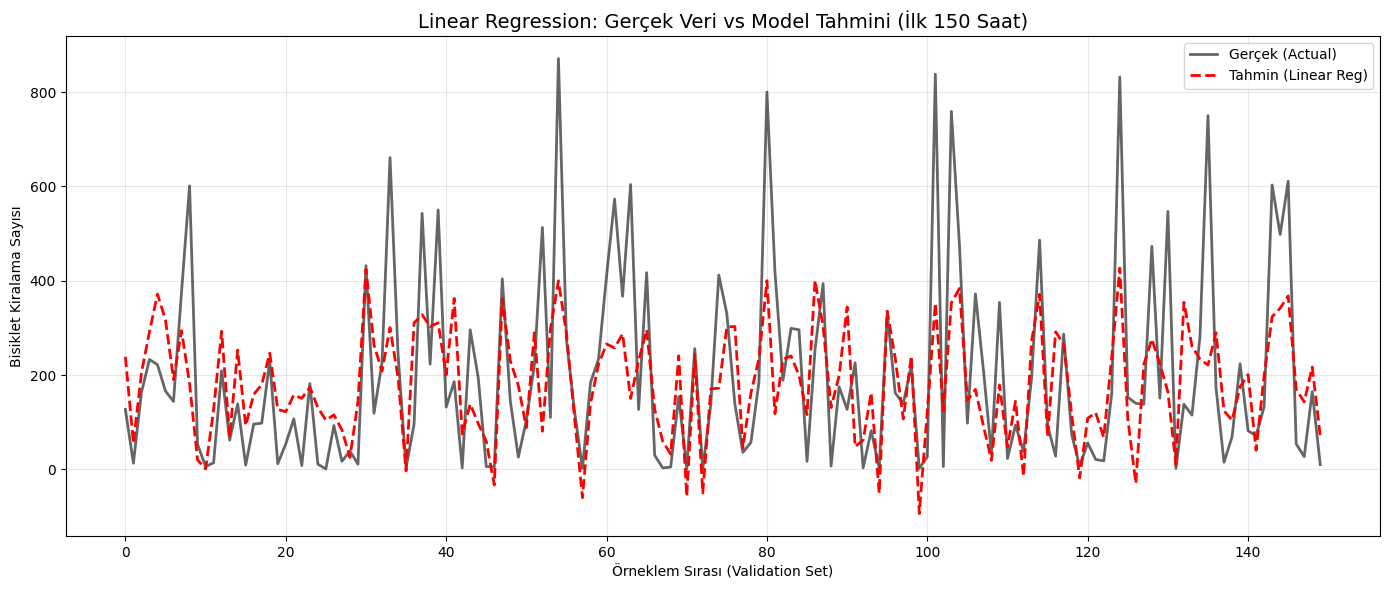

 Modelin saçmaladığı (0'dan küçük tahmin ettiği) durum sayısı: 103


In [7]:
comparison = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred_lr})
comparison = comparison.reset_index(drop=True)

subset = comparison.iloc[:150]

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(subset.index, subset['Actual'], label='Gerçek (Actual)', color='black', alpha=0.6, linewidth=2)

ax.plot(subset.index, subset['Predicted'], label='Tahmin (Linear Reg)', color='red', linestyle='--', linewidth=2)

ax.set_title("Linear Regression: Gerçek Veri vs Model Tahmini (İlk 150 Saat)", fontsize=14)
ax.set_ylabel("Bisiklet Kiralama Sayısı")
ax.set_xlabel("Örneklem Sırası (Validation Set)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()


save_fig_path = root / "figures" / "baseline_actual_vs_pred.png"
plt.savefig(save_fig_path)
print(f"✅ Grafik kaydedildi: {save_fig_path}")

plt.show()


negatives = (y_pred_lr < 0).sum()
print(f" Modelin saçmaladığı (0'dan küçük tahmin ettiği) durum sayısı: {negatives}")

### Negatif Tahmin Sorunu

- **Gözlem:** Modelimiz test sırasında **103** defa "eksi" sayıda bisiklet kiralanacağını tahmin etmiş.
- **Mantık Hatası:** Gerçek hayatta bisiklet kiralama sayısı 0'ın altına düşemez. Ancak Lineer Regresyon sadece matematiksel formüle baktığı için, çizgi aşağı indiğinde eksi değerler üretebiliyor.
- **Sonuç:** Bu durum, Lineer Regresyon'un bu veri seti için tek başına yeterli olmadığını gösteriyor. İlerideki aşamalarda eksi değer üretmeyen veya bu sınırları bilen daha akıllı modeller (karar ağaçları vb.) kullanmalıyım.

In [6]:
test_path = root / "data" / "raw" / "test.csv"
test = pd.read_csv(test_path, parse_dates=['datetime'])


test['hour'] = test['datetime'].dt.hour
test['month'] = test['datetime'].dt.month
test['year'] = test['datetime'].dt.year

X_test = test[features]

test_predictions = lr_model.predict(X_test)


test_predictions = np.maximum(test_predictions, 0)

submission = pd.DataFrame({
    'datetime': test['datetime'],
    'count': test_predictions
})

save_path = root / "data" / "processed" / "submission_baseline.csv"
submission.to_csv(save_path, index=False)

print(f" Submission dosyası kaydedildi: {save_path}")
print("İlk 5 tahmin:")
print(submission.head())

 Submission dosyası kaydedildi: c:\Users\yedis\Desktop\yehu\Github Repo\BikeSharing-ML-Pipeline\data\processed\submission_baseline.csv
İlk 5 tahmin:
             datetime  count
0 2011-01-20 00:00:00  0.000
1 2011-01-20 01:00:00  0.000
2 2011-01-20 02:00:00  0.000
3 2011-01-20 03:00:00  0.000
4 2011-01-20 04:00:00  0.000


#  Baseline Özeti ve Karar

Bu aşamada "en basit" yöntemlerin performansını test ettik ve bir referans noktası belirledik.

### Performans Tablosu

| Model | RMSLE | R² | Durum |
| :--- | :---: | :---: | :--- |
| **Naive (Ortalama)** | `1.58` | `0.00` | Referans noktası. |
| **Linear Regression** | `1.30` | `0.39` | %18 iyileşme var ama yetersiz. |

### Neden Bu Modeli Kullanmayacağız? (Karar)
1.  **Negatif Tahmin:** Model gece saatleri için **eksi (-) sayıda** bisiklet kiralama tahmini yapıyor. Bu gerçek hayata aykırıdır.
2.  **Düz Mantık:** Verideki zikzakları (sabah-akşam trafiği) yakalayamıyor, sadece düz bir çizgi çekiyor.

**Sonuç:** Linear Regression modeli sadece bir "Taban Puan (Benchmark)" olarak kalacaktır. Prodüksiyon (Canlı Sistem) için **Ağaç Tabanlı Modeller (Random Forest, XGBoost vb.)** gereklidir.

**Sıradaki Adım:** `03_feature_engineering.ipynb` -> Veriyi modellerin daha iyi anlayacağı hale getirmek (Örn: Saatleri 'Sabah/Akşam' diye gruplamak).